# CSCB Project

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import anndata
import pySingleCellNet as pySCN
import cospar as cs
import scanpy as sc
cs.settings.verbosity=2
sns.set_style('white')

/Users/wvcui/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/wvcui/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## Read in Data

In [2]:
# read in data
#mcm raw is our engineered mouse cardiomyocytes
adata_mcm_raw=sc.read_h5ad('/Users/wvcui/Desktop/OneDrive - Johns Hopkins/Sp22/Comp SC/final proj/direct_conversion_subsampled_5k_raw.h5ad')

#this is the reference dataset from the tabula muris study
adata_tabmuris=sc.read_h5ad('/Users/wvcui/Desktop/OneDrive - Johns Hopkins/Sp22/Comp SC/final proj/TM_FACS_heart.h5ad')

In [3]:
adata_tabmuris.var.index = adata_tabmuris.var.index.str.upper()
#data['Name'] = data['Name'].str.upper()
adata_tabmuris.var

""
0610005C13RIK
0610007C21RIK
0610007L01RIK
0610007N19RIK
0610007P08RIK
...
ZZEF1
ZZZ3
A
L7RN6


In [4]:
human = sc.read_h5ad('/Users/wvcui/Desktop/OneDrive - Johns Hopkins/Sp22/Comp SC/final proj/human_engineered_cardiomyocytes/hIPSC_CM_orlova_GSM4443382.h5ad')

In [5]:
human.var

,gene_ids
RP11-34P13.3,ENSG00000243485
FAM138A,ENSG00000237613
OR4F5,ENSG00000186092
RP11-34P13.7,ENSG00000238009
RP11-34P13.8,ENSG00000239945
...,...
AC233755.2,ENSG00000277856
AC233755.1,ENSG00000275063
AC240274.1,ENSG00000271254
AC213203.1,ENSG00000277475


In [6]:
#mt and ribo genes, qc metrics
human.var['mt']= human.var_names.str.startswith(("mt-"))
human.var['ribo'] = human.var_names.str.startswith(("Rps","Rpl"))
sc.pp.calculate_qc_metrics(human, qc_vars=['ribo', 'mt'], percent_top=None, log1p=False, inplace=True)

In [7]:
#finding matching genes between datasets
genesTrain = adata_tabmuris.var_names
genesQuery = human.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [8]:
#subsetting for common genes
adata_reference_cgene = adata_tabmuris[:,cgenes]
human = human[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier = human[human.obs["n_genes_by_counts"]>=500,:].copy()

In [9]:
adata_reference_cgene.obs['cell_ontology_class'].unique()


['endothelial cell', 'leukocyte', 'fibroblast', 'myofibroblast cell', 'endocardial cell', 'cardiac muscle cell', 'smooth muscle cell']
Categories (7, object): ['cardiac muscle cell', 'endocardial cell', 'endothelial cell', 'fibroblast', 'leukocyte', 'myofibroblast cell', 'smooth muscle cell']

In [10]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='cell_ontology_class')


/Users/wvcui/opt/anaconda3/lib/python3.9/site-packages/pySingleCellNet/utils.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[cellid] = adata.obs.index


myofibroblast cell : 
178
fibroblast : 
2119
leukocyte : 
523
endocardial cell : 
165
endothelial cell : 
1177
cardiac muscle cell : 
133
smooth muscle cell : 
42


In [11]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'cell_ontology_class', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  734  classification genes

cardiac muscle cell
endocardial cell
endothelial cell
fibroblast
leukocyte
myofibroblast cell
smooth muscle cell
There are 691 top gene pairs

Finished pair transforming the data



<Figure size 6000x4000 with 0 Axes>

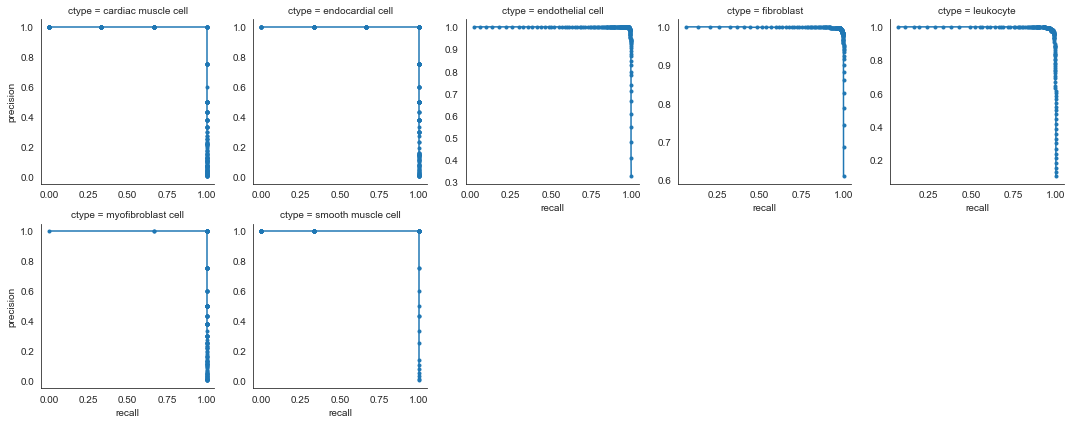

<Figure size 432x288 with 0 Axes>

In [12]:
#classifier on held out test set
plt.figure(dpi=1000)
adVal = pySCN.scn_classify(expVal, cgenesA, xpairs, tspRF, nrand = 0)
assessment =  pySCN.assess_comm(expTrain, adVal, resolution = 0.005, nRand = 0, dLevelSID = "cell", classTrain = "cell_ontology_class", classQuery = "cell_ontology_class")

pySCN.plot_PRs(assessment)
plt.show()
plt.savefig("pyscn_testsetprc.png") #save as png

In [13]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier, cgenesA, xpairs, tspRF, nrand = 0)

In [14]:
adata_mcm_classified.obs

,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,SCN_class
AAACCTGAGAAGGTTT-1,503,1006.0,0.0,0.0,0.0,0.0,leukocyte
AAACCTGAGCATCATC-1,510,1016.0,0.0,0.0,0.0,0.0,cardiac muscle cell
AAACCTGCAGACGTAG-1,2097,6501.0,0.0,0.0,0.0,0.0,fibroblast
AAACCTGGTTTCGCTC-1,657,1227.0,0.0,0.0,0.0,0.0,cardiac muscle cell
AAACGGGGTATAAACG-1,978,2586.0,0.0,0.0,0.0,0.0,leukocyte
...,...,...,...,...,...,...,...
TTTGGTTTCCTGTAGA-1,994,1952.0,0.0,0.0,0.0,0.0,myofibroblast cell
TTTGGTTTCTGTGCAA-1,683,1308.0,0.0,0.0,0.0,0.0,cardiac muscle cell
TTTGTCAGTCTCCACT-1,621,1409.0,0.0,0.0,0.0,0.0,leukocyte
TTTGTCATCCTACAGA-1,537,1065.0,0.0,0.0,0.0,0.0,cardiac muscle cell


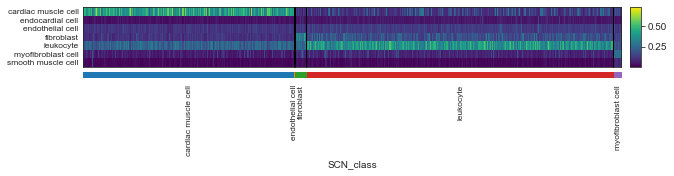

In [15]:
ax = sc.pl.heatmap(adata_mcm_classified, adata_mcm_classified.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)


In [34]:
purity_proportion = adata_mcm_classified.obs.groupby(['SCN_class']).count().iloc[:, 5].to_frame()
purity_proportion = purity_proportion.rename(columns={purity_proportion.columns[0]: 'count'})
purity_proportion['proportion'] = purity_proportion['count']/adata_mcm_classified.obs.shape[0]
purity_proportion = purity_proportion.rename(columns={purity_proportion.columns[1]: 'proportion'})

purity_proportion = purity_proportion.reset_index()
purity_proportion

,SCN_class,count,proportion
0,cardiac muscle cell,1028,0.391918
1,endothelial cell,3,0.001144
2,fibroblast,58,0.022112
3,leukocyte,1496,0.570339
4,myofibroblast cell,38,0.014487


([<matplotlib.patches.Wedge at 0x7fa29becceb0>,
 [Text(0.3663698573288437, 1.037194835911191, 'cardiac muscle cell'),
  Text(-0.8584281158492483, 0.6878235020116061, 'endothelial cell'),
  Text(-0.9063459643359993, 0.6233273561555337, 'fibroblast'),
  Text(-0.3376624984897485, -1.046892562354734, 'leukocyte'),
  Text(1.0988609128646003, -0.05004691976912656, 'myofibroblast cell')])

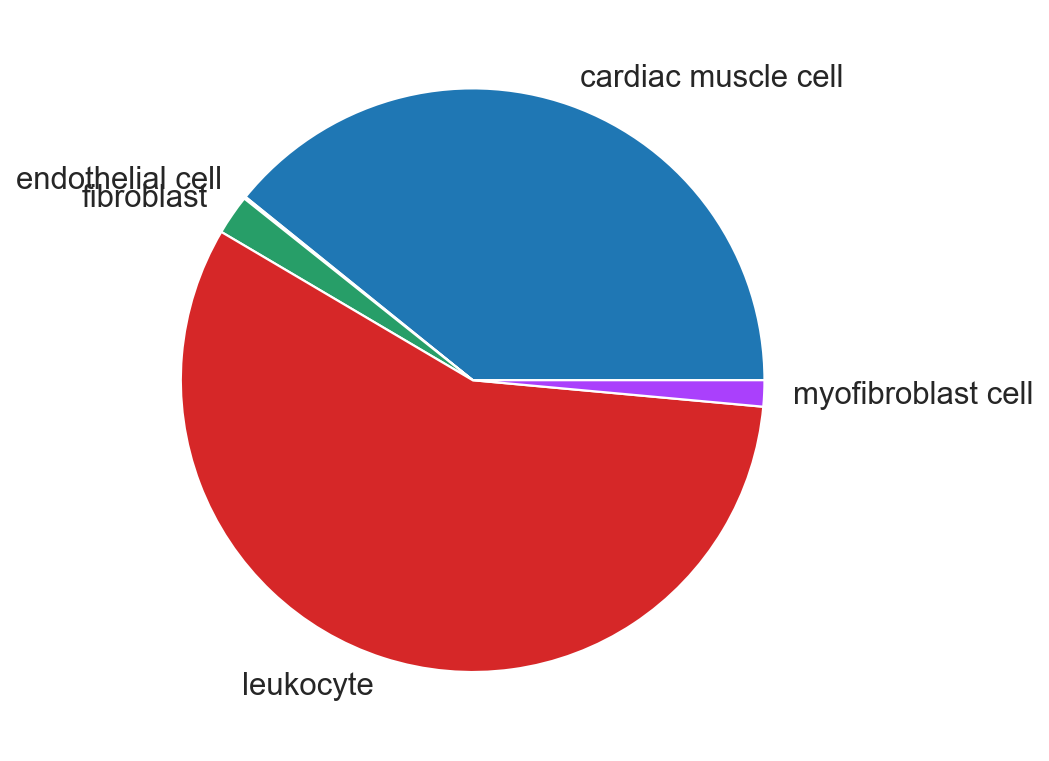

In [35]:
plt.figure(figsize=(10, 6), dpi=80)
plt.pie(purity_proportion['count'], labels = purity_proportion['SCN_class'])


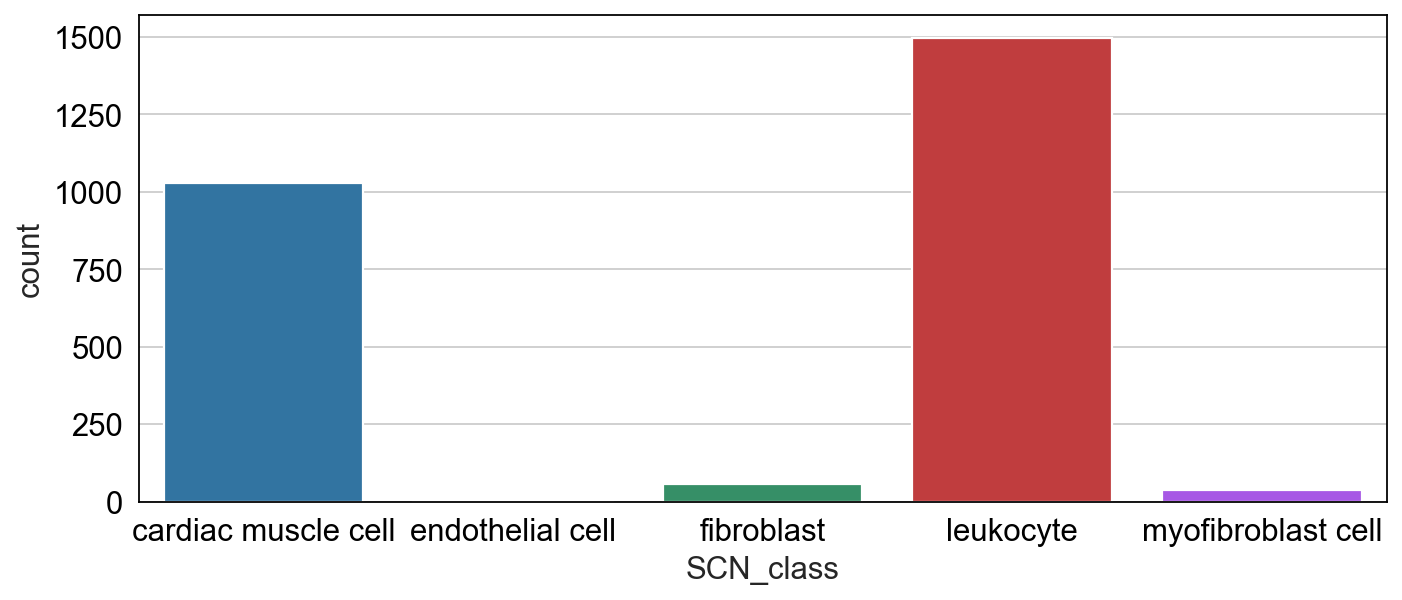

In [36]:
ax = sns.barplot(x='SCN_class', y='count', data=purity_proportion)


# Performing PCA and Leiden clustering 

This section below performs PCA and leiden clustering on the origin human data provided. This section serves as another way to visualize the perform of cardiomyocyte cells in our data based on scoring marker genes for cardiomyocytes. 

In [18]:
human.raw = human
sc.pp.normalize_total(human, target_sum=1e4)
sc.pp.log1p(human)

In [19]:
sc.pp.highly_variable_genes(human, min_mean=0.0125, max_mean=4, min_disp=0.25)


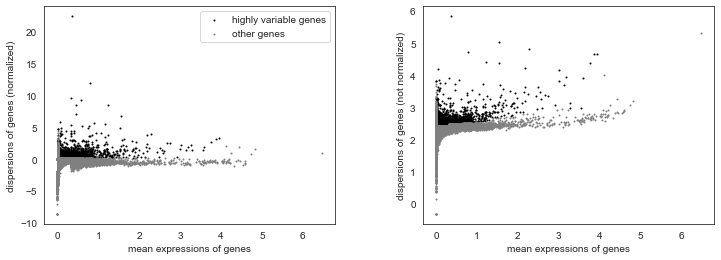

In [20]:
sc.pl.highly_variable_genes(human)


In [21]:
sc.pp.scale(human, max_value=10)


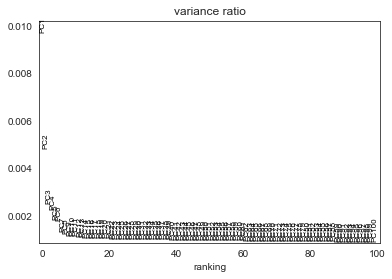

In [22]:
sc.tl.pca(human, n_comps=100)
sc.pl.pca_variance_ratio(human,100, )

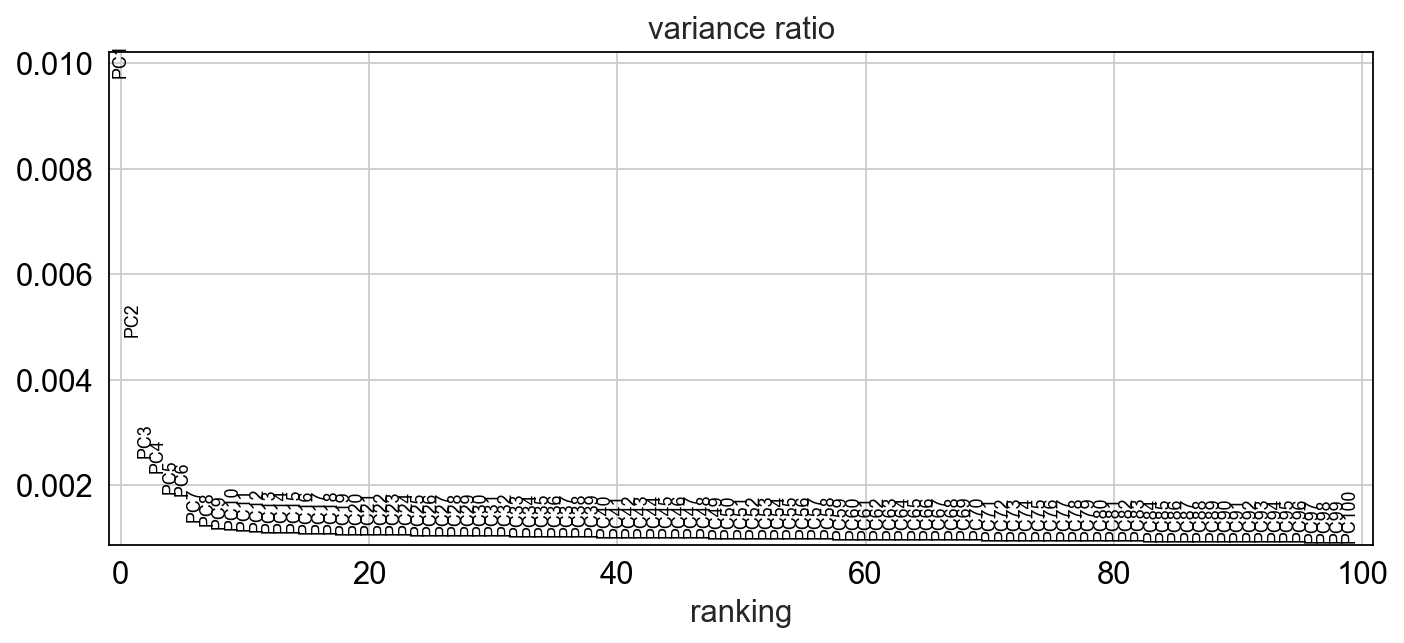

In [23]:
sc.set_figure_params(figsize="10, 4")
sc.pl.pca_variance_ratio(human,100, )


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


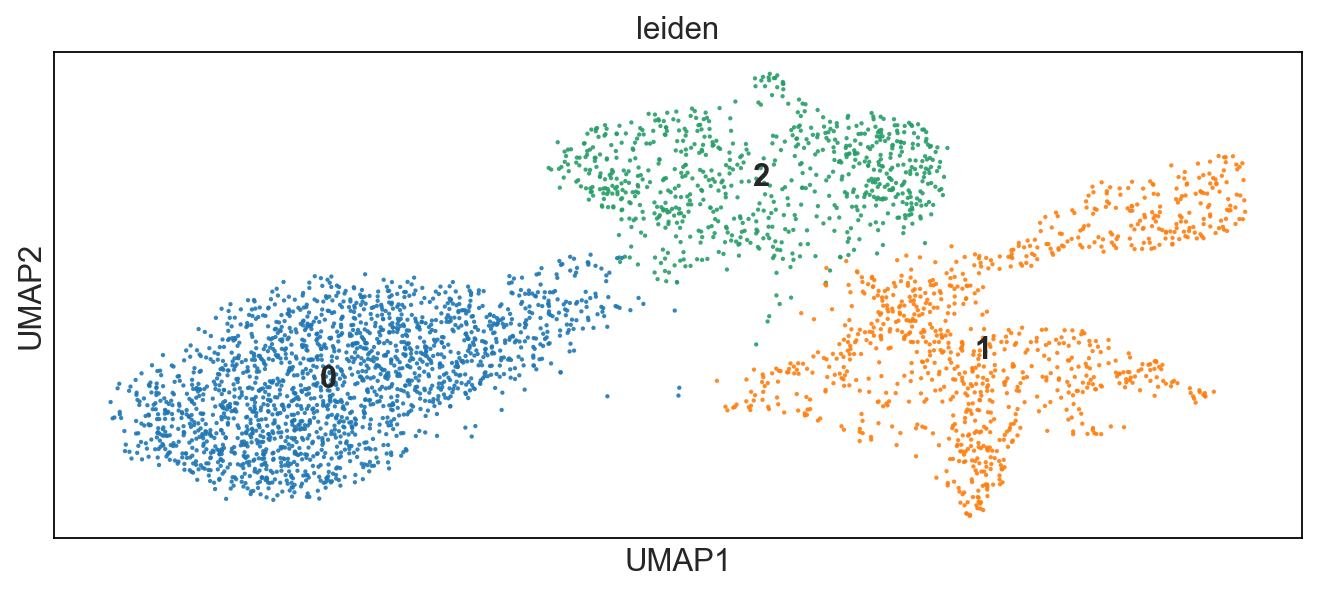

In [24]:
npcs = 20
sc.pp.neighbors(human, n_neighbors=10, n_pcs=npcs)
sc.tl.leiden(human,.1)
sc.tl.umap(human, .5)
sc.pl.umap(human, color=["leiden"], alpha=.9, s=15, legend_loc='on data')

<AxesSubplot:xlabel='PC1', ylabel='PC4'>

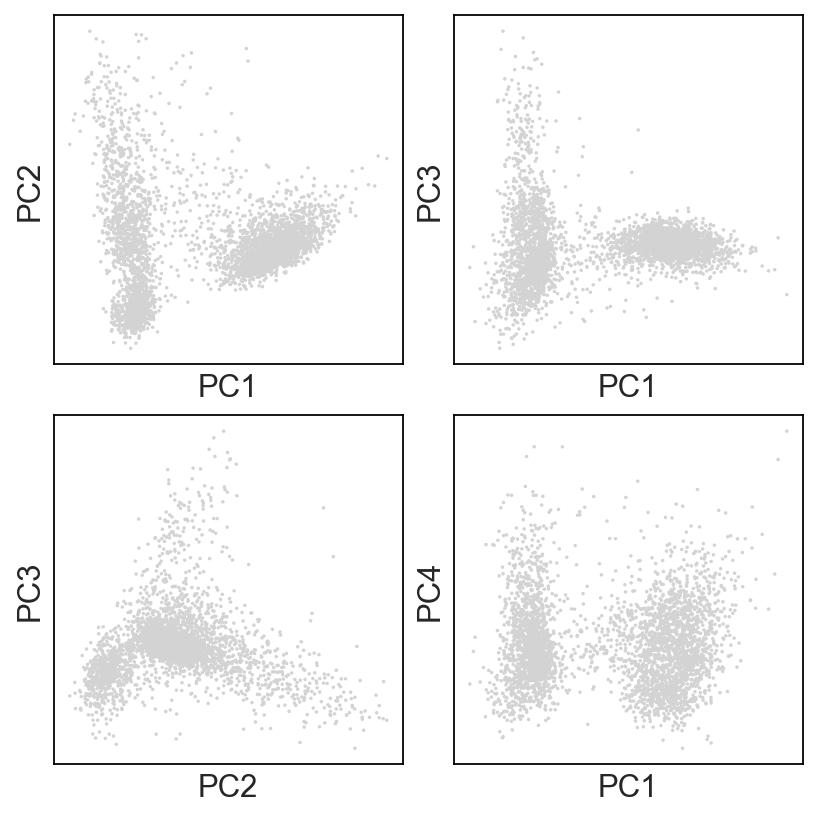

In [25]:
# sc.set_figure_params(figsize="5, 5")
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(human, ax=axs[0,0], show=False, size=10)
sc.pl.pca_scatter(human, components="1,3", ax=axs[0,1], show=False, size=10)
sc.pl.pca_scatter(human, components="2,3", ax=axs[1,0], show=False, size=10)
sc.pl.pca_scatter(human, components="1,4", ax=axs[1,1], show=False, size=10)

In [26]:
# A list of marker genes for cardiomyocyte identified from literature
# citation: Grancharova, T., Gerbin, K.A., Rosenberg, A.B. et al. A comprehensive analysis of gene expression changes in a high replicate and open-source dataset of differentiating hiPSC-derived cardiomyocytes. Sci Rep 11, 15845 (2021). https://doi.org/10.1038/s41598-021-94732-1

cm_genes = pd.read_csv('/Users/wvcui/Desktop/OneDrive - Johns Hopkins/Sp22/Comp SC/final proj/cm genes.csv')

In [27]:
cardiac_genes = cm_genes['Genes']

In [28]:
sc.tl.score_genes(human, gene_list = cardiac_genes, score_name = "cardiac_genes")

In [43]:
# calculating the percent of cells expressing the CM marker genes. The threshold here is set to 0.1
print('The proportion of cells expressing CM marker genes: ' + str(human.obs[human.obs['cardiac_genes']>0.1].shape[0]/human.obs.shape[0]))

The proportion of cells expressing CM marker genes: 0.48712328767123286


<AxesSubplot:title={'center':'cardiac_genes'}, xlabel='PC1', ylabel='PC5'>

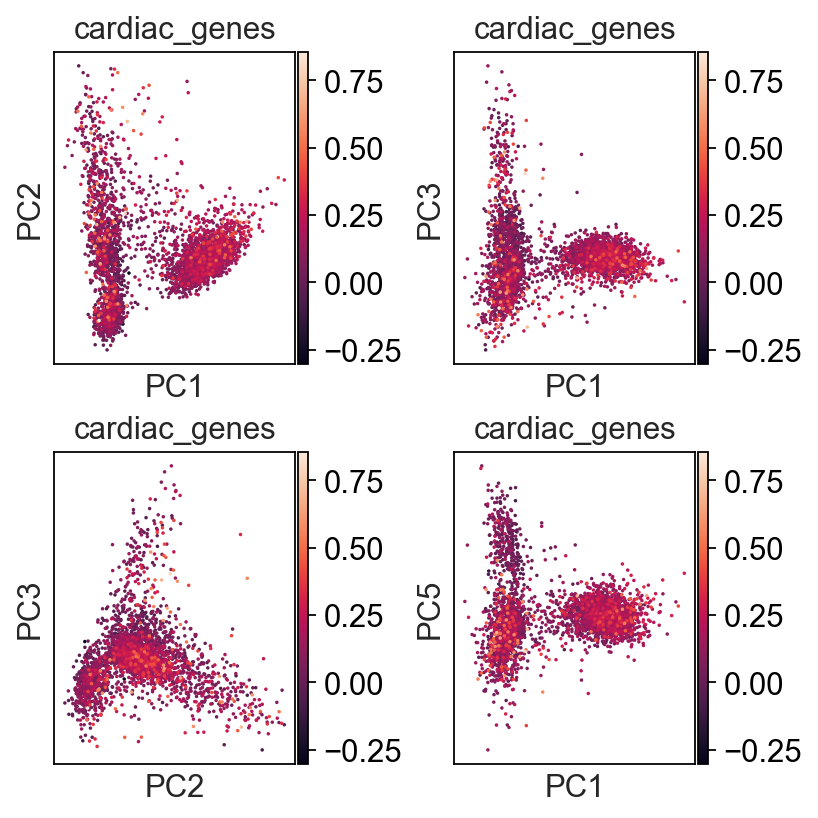

In [31]:
fig, axs = plt.subplots(2,2, figsize=(5,5), constrained_layout=True)
sc.pl.pca_scatter(human, ax=axs[0,0], color = "cardiac_genes", show=False, size=10)
sc.pl.pca_scatter(human, components="1,3", ax=axs[0,1], color = "cardiac_genes", show=False, size=10)
sc.pl.pca_scatter(human, components="2,3", ax=axs[1,0], color = "cardiac_genes", show=False, size=10)
sc.pl.pca_scatter(human, components="1,5", ax=axs[1,1], color = "cardiac_genes", show=False, size=10)

As the PCA plots above shown, based on our threshold = 0.1, around half of the cells in our data are expressing the cardiomyocyte marker genes (around 0.49), which mataches up with our results from the pySCN classifier (around 0.39). 

## Q2

In [44]:
adata_kannan=sc.read_h5ad('/Users/wvcui/Desktop/OneDrive - Johns Hopkins/Sp22/Comp SC/final proj/perinatal_reference_data/Kannan_perinatal_reference.h5ad')

In [45]:
adata_kannan #raw counts

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

In [46]:
adata_kannan.var.index = adata_kannan.var.index.str.upper()
#data['Name'] = data['Name'].str.upper()
adata_kannan.var

""
GNAI3
PBSN
CDC45
H19
SCML2
...
5730414N17RIK
GM49463
GM49494
4930414F18RIK


In [47]:
human.obs['scn_class']=adata_mcm_classified.obs['SCN_class']
adata_mcm_classifier_mcmcalls=human[human.obs['scn_class']=='cardiac muscle cell']

In [48]:
#finding matching genes between datasets
genesTrain = adata_kannan.var_names
genesQuery = adata_mcm_classifier_mcmcalls.var_names
cgenes = genesTrain.intersection(genesQuery)
#around 14k genes remanining

In [49]:
len(cgenes)

13438

In [50]:
#subsetting for common genes
adata_reference_cgene = adata_kannan[:,cgenes]
adata_mcm_classifier_mcmcalls = adata_mcm_classifier_mcmcalls[:,cgenes].copy()

#following the pyscCellNet vignette on github. im guessing cells with more than 500 
adata_mcm_classifier_mcmcalls = adata_mcm_classifier_mcmcalls[adata_mcm_classifier_mcmcalls.obs["n_genes_by_counts"]>=500,:].copy()





In [51]:
adata_reference_cgene.obs['timepoint'].unique()

['e18', 'e14', 'p0', 'p4', 'p14', ..., 'p35', 'p56', 'p18', 'p11', 'p8']
Length: 12
Categories (12, object): ['e14', 'e18', 'p0', 'p4', ..., 'p22', 'p28', 'p35', 'p56']

In [52]:
expTrain, expVal = pySCN.splitCommonAnnData(adata_reference_cgene, ncells=200,dLevel='timepoint')




p0 : 
35
p11 : 
93
p4 : 
36
p18 : 
89
p56 : 
94
p28 : 
77
e14 : 
72
p14 : 
92
p8 : 
82
p35 : 
91
e18 : 
83
p22 : 
92


In [53]:
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expTrain, nTopGenes = 100, nRand = 0,
                                           nTrees = 1000 ,nTopGenePairs = 100, dLevel = 'timepoint', 
                                           stratify=True, limitToHVG=True)

HVG
Matrix normalized
There are  1210  classification genes

e14
e18
p0
p11
p14
p18
p22
p28
p35
p4
p56
p8
There are 1167 top gene pairs

Finished pair transforming the data



<Figure size 10000x4000 with 0 Axes>

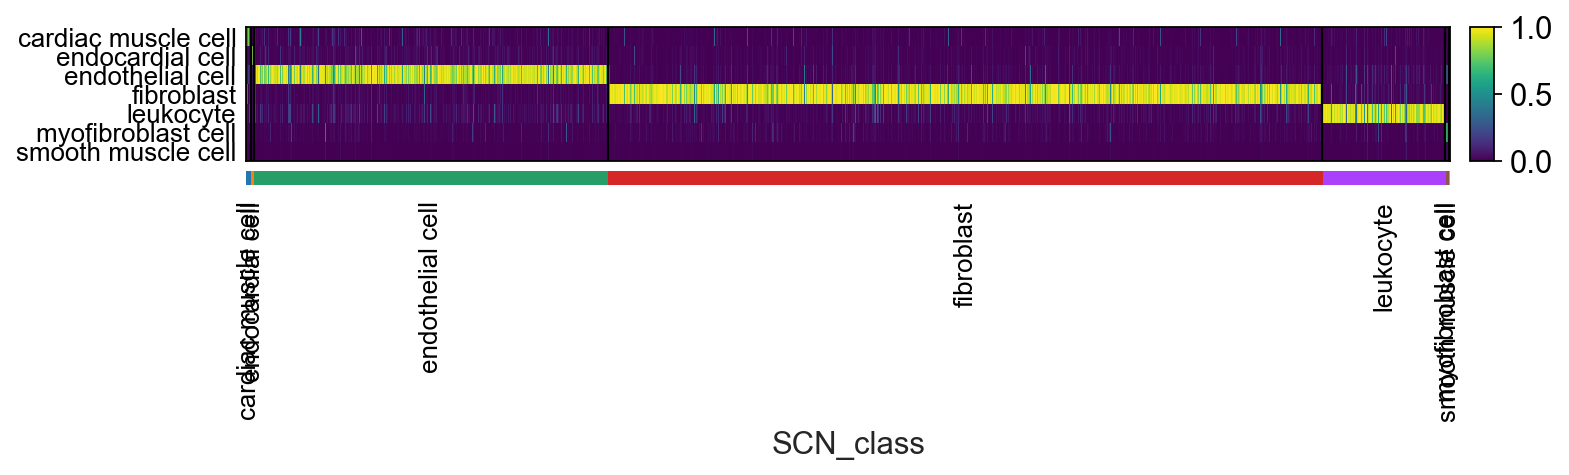

In [54]:
plt.figure(dpi=1000)
ax = sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)


In [55]:
#use classifier on old hsc data
adata_mcm_classified = pySCN.scn_classify(adata_mcm_classifier_mcmcalls, cgenesA, xpairs, tspRF, nrand = 0)

adata_mcm_classified.obs


,n_genes_by_counts,total_counts,total_counts_ribo,pct_counts_ribo,total_counts_mt,pct_counts_mt,leiden,cardiac_genes,scn_class,SCN_class
AAACCTGAGCATCATC-1,510,1016.0,0.0,0.0,0.0,0.0,0,0.135216,cardiac muscle cell,e18
AAACCTGGTTTCGCTC-1,657,1227.0,0.0,0.0,0.0,0.0,0,0.044297,cardiac muscle cell,e14
AAACGGGGTGAAGGCT-1,610,1460.0,0.0,0.0,0.0,0.0,0,0.236102,cardiac muscle cell,e18
AAACGGGTCGTCACGG-1,579,1103.0,0.0,0.0,0.0,0.0,0,0.135493,cardiac muscle cell,e18
AAAGATGAGTTCCACA-1,505,760.0,0.0,0.0,0.0,0.0,0,0.043937,cardiac muscle cell,e18
...,...,...,...,...,...,...,...,...,...,...
TTTGCGCTCCTCCTAG-1,502,869.0,0.0,0.0,0.0,0.0,0,0.041556,cardiac muscle cell,p8
TTTGGTTGTGTTAAGA-1,672,1311.0,0.0,0.0,0.0,0.0,0,0.152879,cardiac muscle cell,e18
TTTGGTTGTTTCGCTC-1,746,1753.0,0.0,0.0,0.0,0.0,0,0.188123,cardiac muscle cell,e18
TTTGGTTTCTGTGCAA-1,683,1308.0,0.0,0.0,0.0,0.0,0,0.279236,cardiac muscle cell,p8


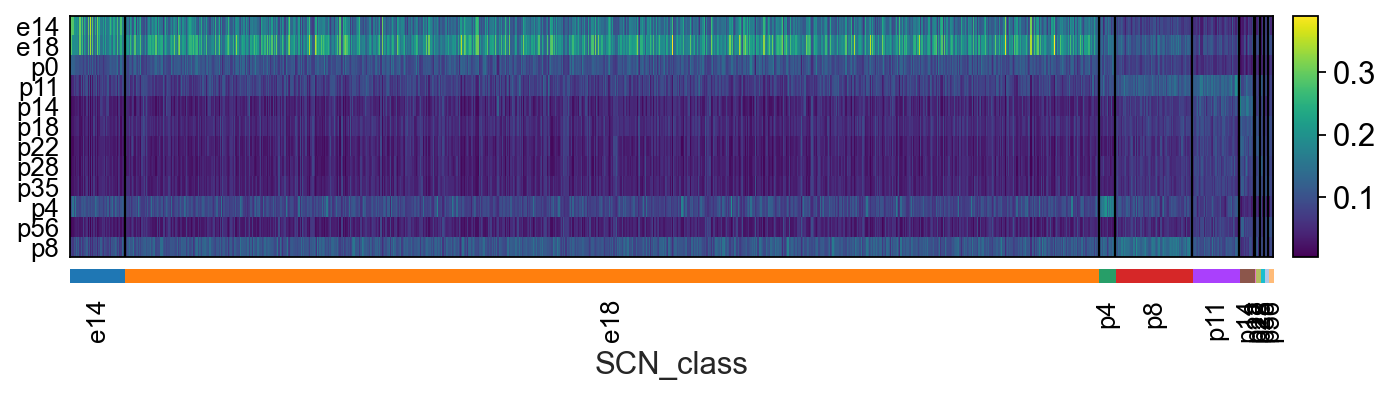

In [56]:
ax = sc.pl.heatmap(adata_mcm_classified, adata_mcm_classified.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True)


In [57]:
maturity_proportion = adata_mcm_classified.obs.groupby(['SCN_class']).count().iloc[:,6].to_frame()
maturity_proportion = maturity_proportion.rename(columns={maturity_proportion.columns[0]: 'count'})
maturity_proportion['proportion'] = maturity_proportion['count']/adata_mcm_classified.obs.shape[0]
maturity_proportion = maturity_proportion.rename(columns={maturity_proportion.columns[1]: 'proportion'})

maturity_proportion = maturity_proportion.reset_index()
maturity_proportion

,SCN_class,count,proportion
0,e14,47,0.045720
1,e18,832,0.809339
2,p4,14,0.013619
3,p8,66,0.064202
4,p11,40,0.038911
5,p14,13,0.012646
6,p18,1,0.000973
7,p22,4,0.003891
8,p28,3,0.002918
9,p35,4,0.003891


In [58]:
adata_mcm_classified.obs.shape[0]

1028

([<matplotlib.patches.Wedge at 0x7fa29e112fd0>,
 [Text(1.0886727331385406, 0.15745373962107093, 'e14'),
  Text(-1.046990066148734, 0.33736004710971607, 'e18'),
  Text(0.7110640976452496, -0.8392781714306331, 'p4'),
  Text(0.8930694482677196, -0.6422047652974797, 'p8'),
  Text(1.0510356402544747, -0.3245367204414113, 'p11'),
  Text(1.0896147400219778, -0.15079694402353708, 'p14'),
  Text(1.0950674014670254, -0.10405472715959035, 'p18'),
  Text(1.0965294714926668, -0.08731046986480549, 'p22'),
  Text(1.098146199259456, -0.06383513963336669, 'p28'),
  Text(1.0992604072135697, -0.040330597970487984, 'p35'),
  Text(1.0999178138368506, -0.013446293331753732, 'p56')])

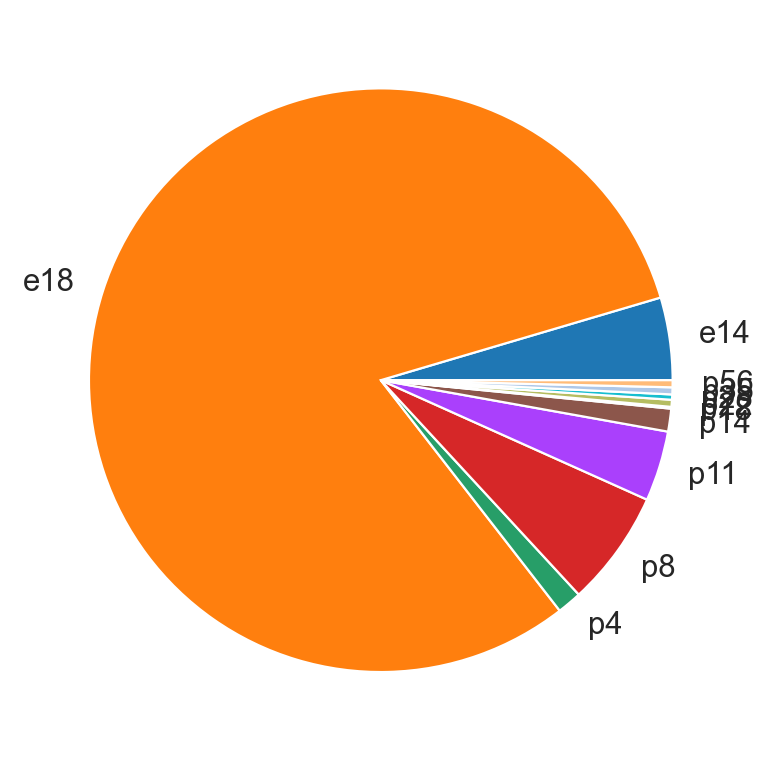

In [59]:
plt.figure(figsize=(10, 6), dpi=80)
plt.pie(maturity_proportion['count'], labels = maturity_proportion['SCN_class'])


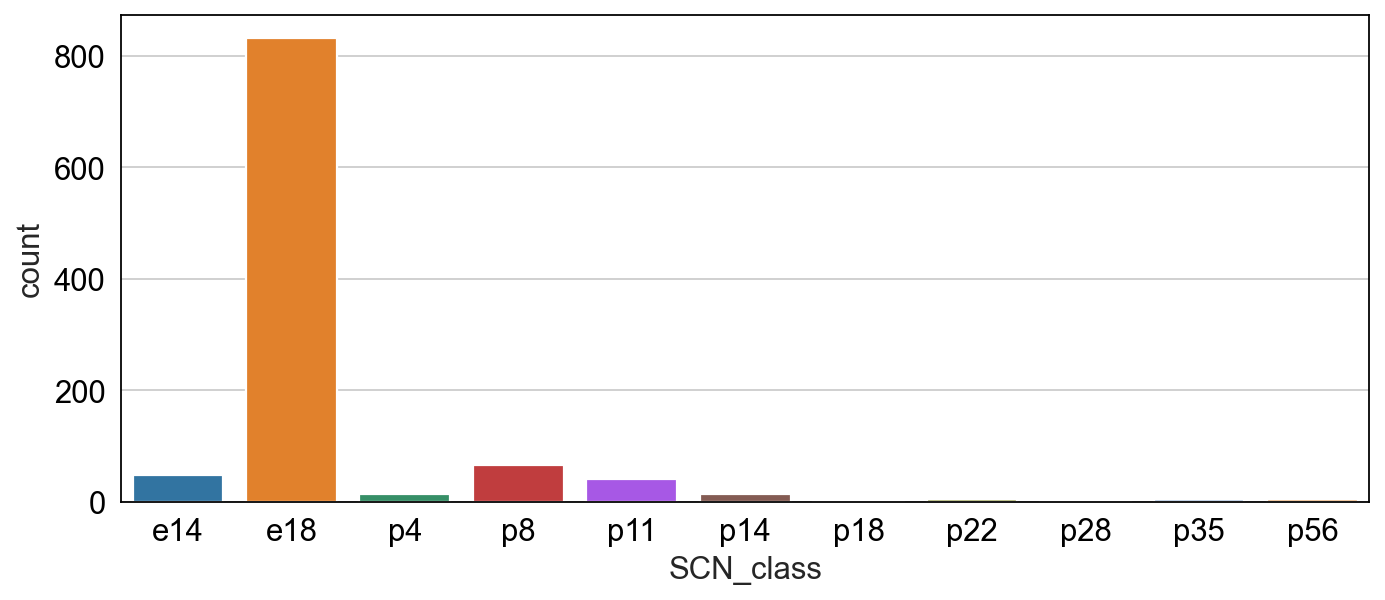

In [60]:
ax = sns.barplot(x='SCN_class', y='count', data=maturity_proportion)
